<h1> Self-Driving Car Engineer Nanodegree

<h2> Project: Advanced Lane Finding

Below are the steps for this project:

* Find out the camera caibration matrix and distortion coefficient given a set of chessboard images

* Apply the distortion correction on the images

* Calculate the gradient and color threshold to output binary thresholded images

* Apply a perspective transform to get the bird's eye view of the lane lines in the images

* Locate lane lines and fit a polynomial

* Determine the lane curvature and vehicle position with respect to the center of the lane

* Perform Inverse Transform

* Final Pipeline

In [1]:
import imageio
imageio.plugins.ffmpeg.download()
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

Plotting function

In [2]:
def plt_images(img, original_title, undistorted, new_title):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title(original_title, fontsize=30)
    ax2.imshow(undistorted)
    ax2.set_title(new_title, fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

<h2> Camera Calibration

(720, 1280, 3)


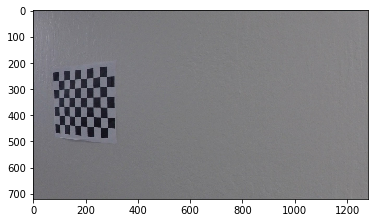

In [3]:
img = mpimg.imread('camera_cal/calibration11.jpg')
image_shape = img.shape
print(image_shape)
plt.imshow(img)

In the above image we can observe that there are 9 inside corners in x and 6 inside corners in y 

In [4]:
def calibrate_camera(image_path):
    nx = 9 # no of inside corners in x
    ny = 6 # no of inside corners in y

    objpoints = [] # list to store 3D points in real world space
    imgpoints = [] # list to store 2D points in image plane

    objp = np.zeros((nx*ny,3), np.float32) # prepare object points like (0, 0, 0), (1, 0, 0).....(8, 5, 0)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # x, y coordinates

    # read and make a list of all the calibration images
    calibration_images = glob.glob(image_path)

    for image in calibration_images:
        img = mpimg.imread(image) # read a single image
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # convert image to grayscale
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None) # find chessboard corners
        # if corners are found add Object points and image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    # calibrate the camera and compute camera matrix and distortion coefficients
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_shape[:2],None,None)
    return (mtx, dist)
    
mtx, dist = calibrate_camera("camera_cal/calibration*.jpg") 

<h2> Distortion Correction 

use the camera matrix and distortion coefficient calculated above to undistort the image

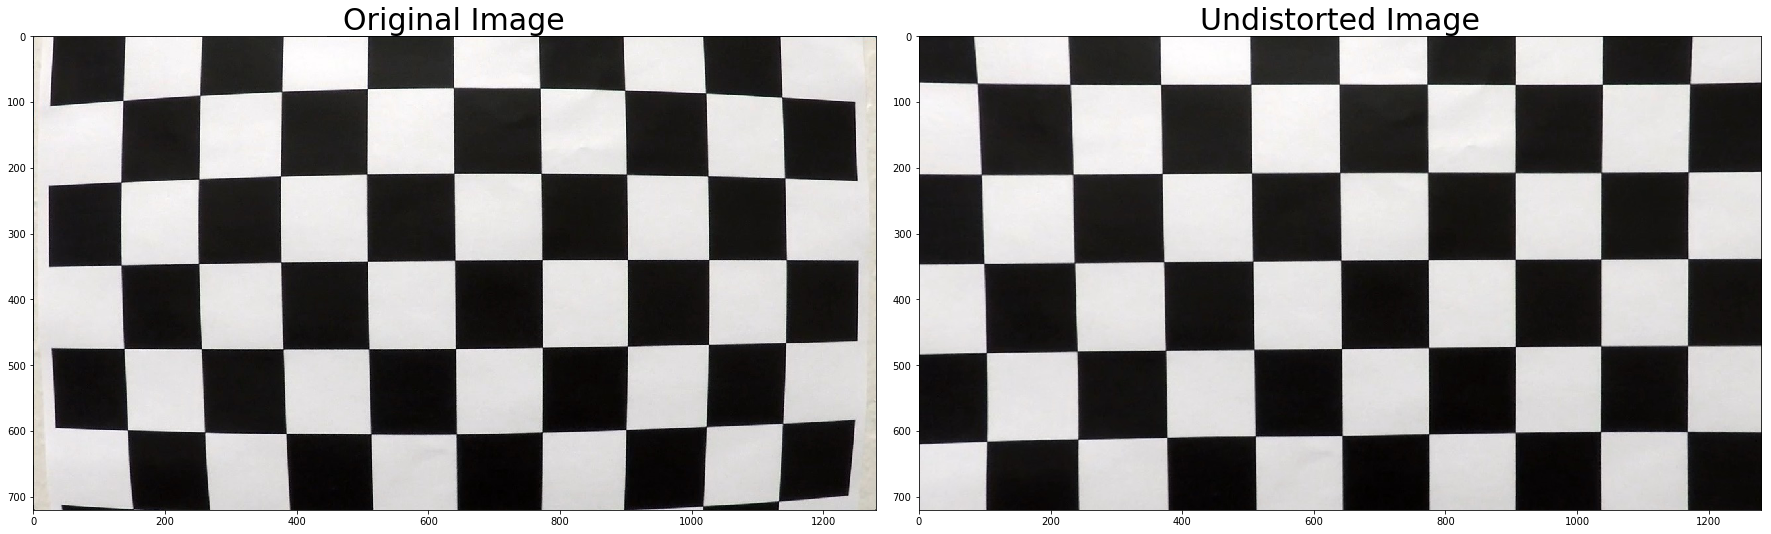

In [5]:
def undistort_image(img, mtx, dist):
    undistorted = cv2.undistort(img, mtx, dist, None, mtx) # undistort the image
    return undistorted
    
img = mpimg.imread('camera_cal/calibration1.jpg') # read calbration image
undistorted = undistort_image(img, mtx, dist)
plt_images(img, 'Original Image', undistorted, 'Undistorted Image')

Example on the test image

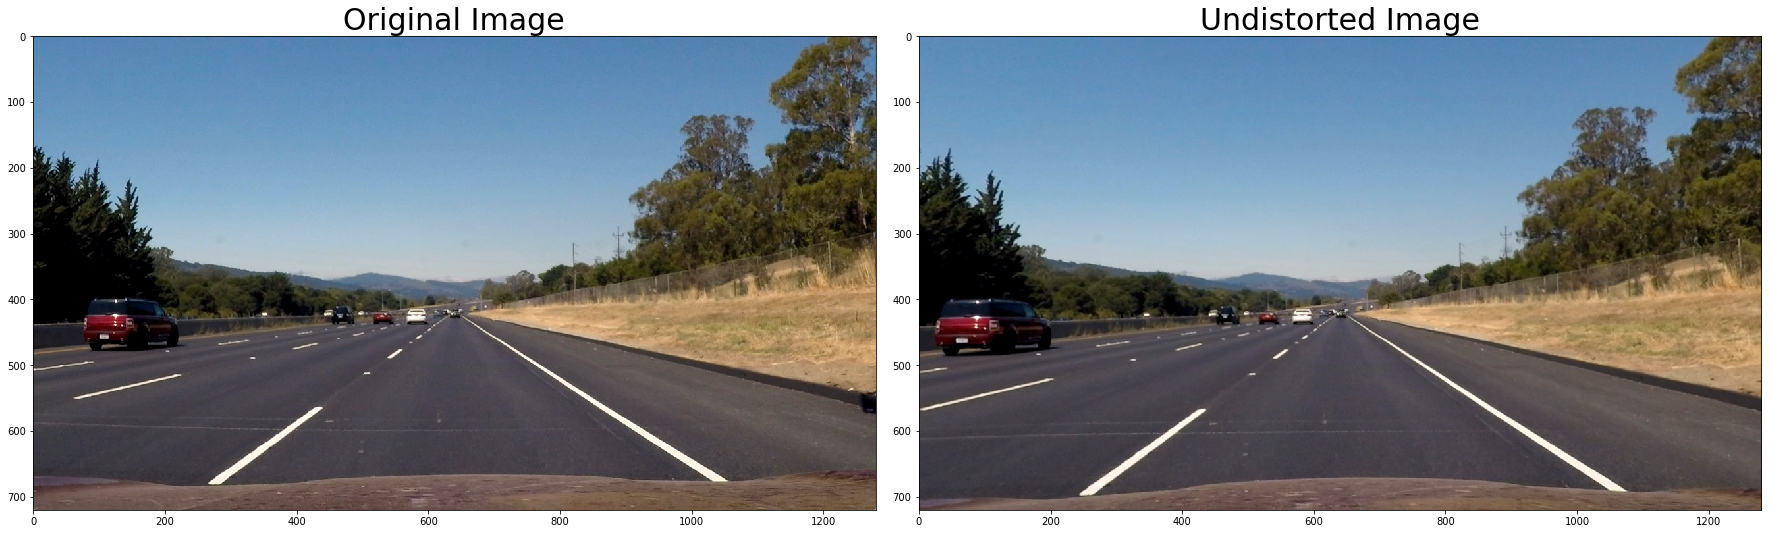

In [6]:
img = mpimg.imread('test_images/straight_lines2.jpg') # read test image
undistorted = undistort_image(img, mtx, dist)
plt_images(img, 'Original Image', undistorted, 'Undistorted Image')

<h2> Gradient & Color Threshold 

<h3> Gradient Threshold

In this project, two types of gradient threshold are used

* Sobelx Threshold which emphasizes the edges closer to vertical and was giving good result with the images

* Directional Gradient as we are interested in finding edges in a particular orientation

<h3> Color Threshold

Three types of color thresholds are used

* R and G channel threshold as they are high for white and yellow lane lines but their values change under varying levels of brightness so alone it is not sufficient

* L channel threshold so that edges generated decause of shadows can be ignored

* S Channel threshold as it stays fairly consistent even in shadow or excessive brightness and detects both the white and yellow lane lines

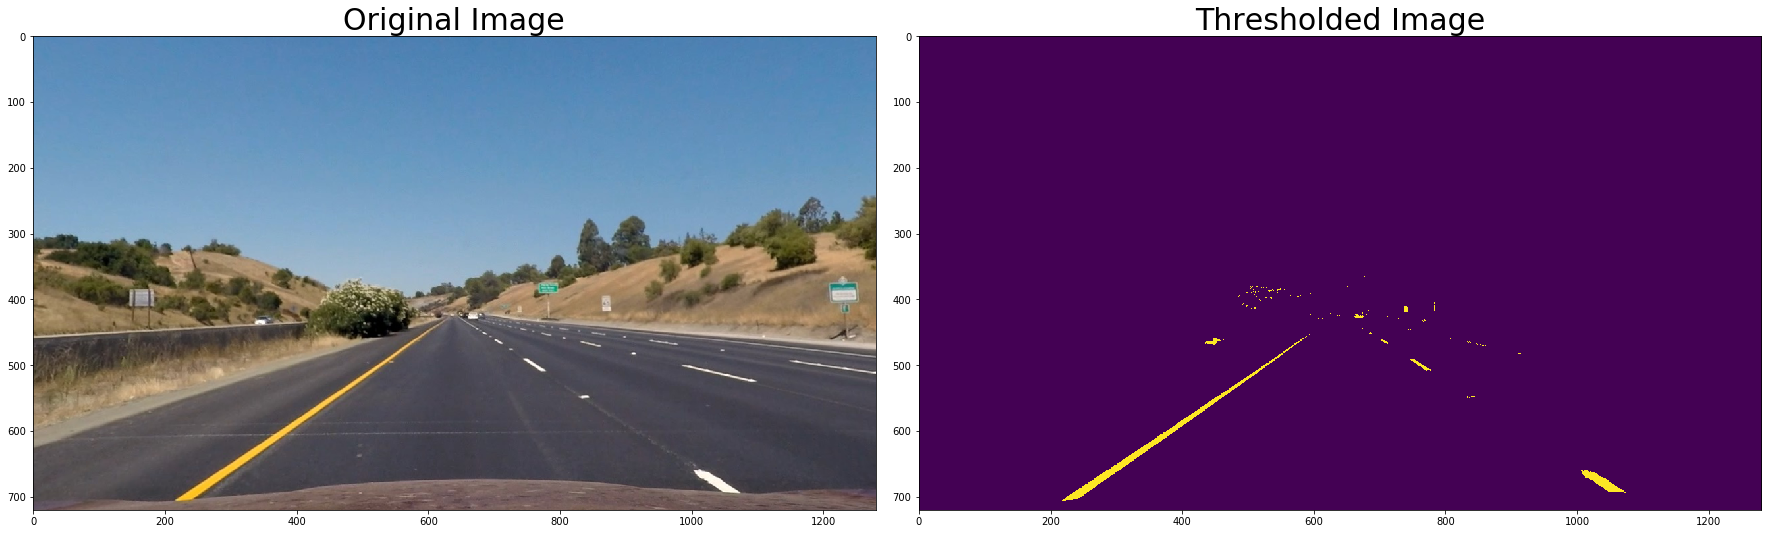

In [7]:
def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel) # Apply sobel operator in x direction
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel) # Apply sobel operator in y direction
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx)) # Take the absolute values of the gradient and calculate the direction
    binary_output =  np.zeros_like(absgraddir) 
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1 # create a binary mask where direction thresholds are met
    return binary_output

def abs_sobel_thresh(gray, orient='x', thresh_min=0, thresh_max=255):
    # take the absolue value of the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel)) # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1 #  Create a mask of 1's where the scaled gradient magnitude is > thresh_min and < thresh_max
    return binary_output

def retrieve_thresholded_image(img): 
    img = cv2.undistort(img, mtx, dist, None, mtx) #undistort the image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # convert to gray scale
    height, width = gray.shape # get the shape the image and store in height and width
    
    # apply gradient thresholding
    sx_binary = abs_sobel_thresh(gray, 'x', 15, 210) # gradient threshold in the x direction
    direction_binary = dir_threshold(gray, thresh=(0.5, 1.4))  # gradient direction threshold
    gradient_combined = ((sx_binary == 1) & (direction_binary == 1))  # apply both the gradient and direction thresholds.
    
    # apply color thresholding
    r_g_threshold = 170 # R & G color space threshold
    R = img[:,:,0] # take out only Red color channel
    G = img[:,:,1] # take out only Green color channel
    r_g_combined = (R > r_g_threshold) & (G > r_g_threshold)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS) # convert to hls color space
    S = hls[:,:,2] # take out only Saturation color channel
    L = hls[:,:,1] # take out only Lightness color channel
    s_threshold = (90, 255)
    s_combined = (S > s_threshold[0]) & (S <= s_threshold[1])
    l_threshold = (110, 255)
    l_combined = (L > l_threshold[0]) & (L <= l_threshold[1])
    
    combined_color = np.zeros_like(R)
    combined_color[(r_g_combined & l_combined) & (s_combined | gradient_combined)] = 1  # combine all the thresholds
    
    # apply the region of interest mask
    mask = np.zeros_like(combined_color)
    region_of_interest_vertices = np.array([[0,height-1], [width/2, int(0.4*height)], [width-1, height-1]], dtype=np.int32)
    cv2.fillPoly(mask, [region_of_interest_vertices], 1)
    thresholded = cv2.bitwise_and(combined_color, mask)
    return thresholded

img = mpimg.imread('test_images/straight_lines1.jpg')
thresholded = retrieve_thresholded_image(img)
img = undistort_image(img, mtx, dist)
plt_images(img, 'Original Image', thresholded, 'Thresholded Image')

<h2> Perspective Transform 

After manual examination of the image the source and destination points for perspective transform are choosen. The destination points are choosen manually so that the lane lines appear more or less parallel in the warped image. 

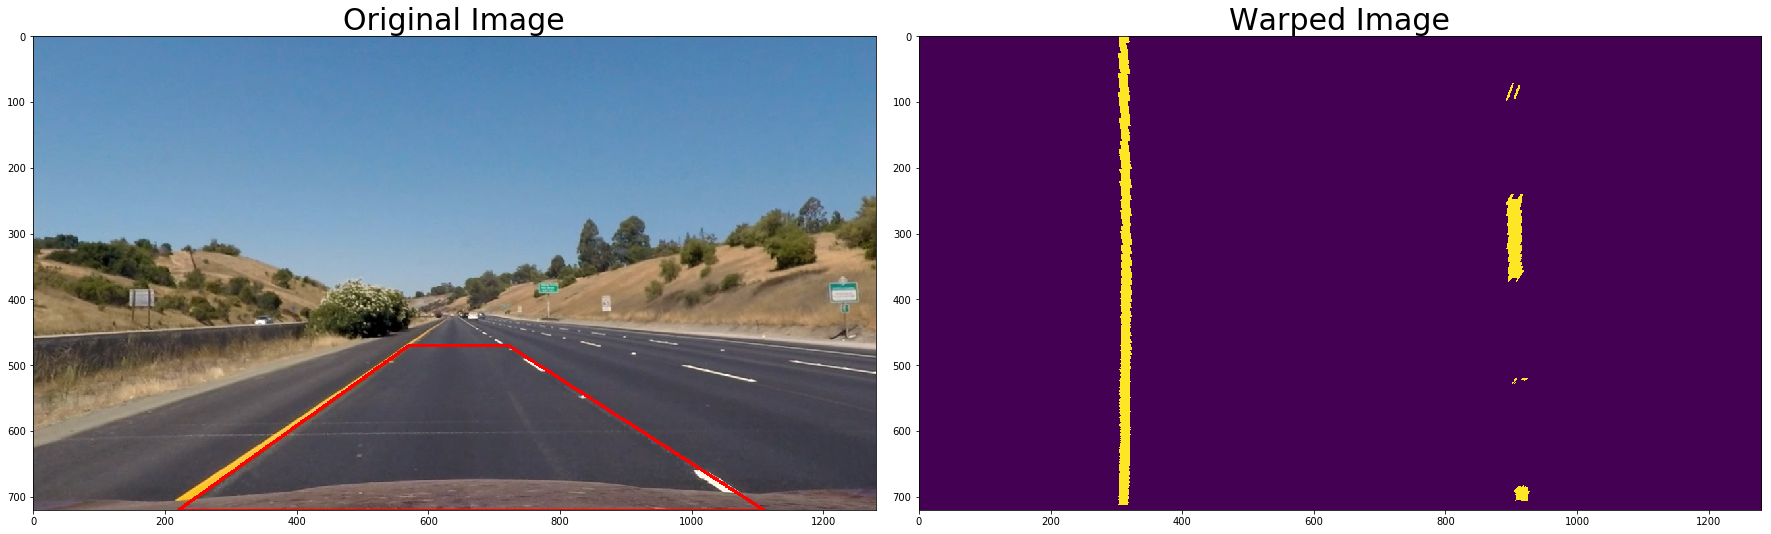

In [8]:
def calculate_perspective_transorm(img_shape, thresholded):
    # harcoded x, y coordinates for the source points
    bottom_left = [220,720]
    bottom_right = [1110, 720]
    top_left = [570, 470]
    top_right = [722, 470]

    #draw the red color polylines joining the above mentioned points
    points = np.array([bottom_left,bottom_right,top_right,top_left], np.int32)
    points = points.reshape((-1,1,2))
    src = np.float32([bottom_left,bottom_right,top_right,top_left]) # create source points

    # harcoded x, y coordinates for the destination points
    bottom_left = [320,720]
    bottom_right = [920, 720]
    top_left = [320, 1]
    top_right = [920, 1]

    dst = np.float32([bottom_left,bottom_right,top_right,top_left]) # create destination points
    M = cv2.getPerspectiveTransform(src, dst) # Given src and dst points, calculate the perspective transform matrix
    M_inv = cv2.getPerspectiveTransform(dst, src)
    img_size = (img_shape[1], img_shape[0]) # get the image size 
    warped = cv2.warpPerspective(thresholded, M, img_size) # Warp the image using OpenCV warpPerspective()
    return(M, M_inv, warped, points)

M, M_inv, warped, points = calculate_perspective_transorm(image_shape, thresholded)
src_copy = img.copy()
cv2.polylines(src_copy,[points],True,(255,0,0), thickness=3)
plt_images(src_copy, 'Original Image', warped, 'Warped Image') # plot the images

<h2> Locate Lane Lines and Fit a polynomial

<h3> Histogram peaks

The peaks in the histogram tells us the likely position of the lane lines in the image

308 908


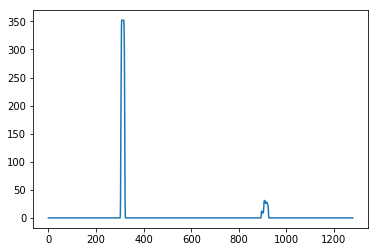

In [9]:
def calculate_histogram(warped):
    histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
    # first half peak will indicate the position of left lane lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_position = np.argmax(histogram[:midpoint])
    # second half peak will indicate the likely position of the right lane lines
    rightx_position = np.argmax(histogram[midpoint:]) + midpoint
    return(leftx_position, rightx_position, histogram)

leftx_position, rightx_position, histogram = calculate_histogram(warped)
print(leftx_position, rightx_position)
plt.plot(histogram)

<h3> Sliding window search

In my thresholded binary image, pixels are either 0 or 1, so the two most prominent peaks in the above histogram are good indicators of the x-position of the base of the lane lines so the points can be used as a starting point for where to search for the lines. From that point a sliding window is placed around the line centers to find and follow the lines up to the top of the frame. I have used 10 windows of width 100 pixels.

(720, 0)

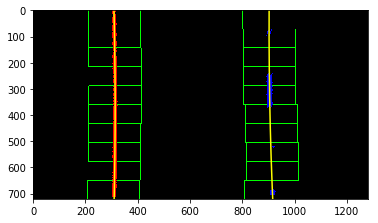

In [10]:
def sliding_window_search(warped, leftx_position, rightx_position, nwindows=10, margin=100):
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((warped, warped, warped))*255
    # Set height of windows
    window_height = np.int(warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_position
    rightx_current = rightx_position
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped.shape[0] - (window+1)*window_height
        win_y_high = warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    return(left_fit, right_fit, left_lane_inds, right_lane_inds, out_img)

left_fit, right_fit, left_lane_inds, right_lane_inds, out_img = sliding_window_search(warped, leftx_position, rightx_position)
ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

Skipping the sliding windows step once we know where the lines are. Since consecutive frames are likely to have lane lines in roughly similar positions, so we search around a margin of 80 pixels of the previously detected lane lines.

(720, 0)

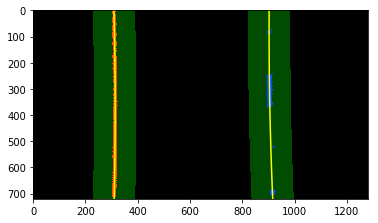

In [11]:
def polyfit_based_on_previous_frame(warped, left_fit, right_fit):
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit_new, right_fit_new = (None, None)
    if len(leftx) != 0:
        # Fit a second order polynomial to each
        left_fit_new = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit_new = np.polyfit(righty, rightx, 2)
    return (left_fit_new, right_fit_new, left_lane_inds, right_lane_inds)

nonzero = warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 80
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
left_fit[1]*nonzeroy + left_fit[2] + margin))) 

right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((warped, warped, warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

<h2> Measuring Curvature

In the above section we have estimated which pixels belong to the left and right lane lines and also fit a polynomial to those pixel positions. Now we'll compute the radius of curvature of the fit after converting our x and y values to the real world space. For this project, I have assumed that if you're projecting a section of the lane, the lane is about 30 meters long and 3.7 meters wide.

I have assumed that the camera is mounted at the center of the car, such that the lane center is the midpoint at the bottom of the image between the two lines detected earlier. The offset of the lane center from the center of the image (converted from pixels to meters) is the distance from the center of the lane.

In [12]:
def compute_radius_of_curvature_in_mtrs(x_positions):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Fit new polynomials to x,y in world space
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    # Define y-value where we want radius of curvature
    # I have choosen the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    fit_cr = np.polyfit(ploty*ym_per_pix, x_positions*xm_per_pix, 2)
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    return curverad

left_curve = compute_radius_of_curvature_in_mtrs(left_fitx)
right_curve = compute_radius_of_curvature_in_mtrs(right_fitx)
average_curve = (left_curve + right_curve)/2
curvature = "Radius of curvature: %.2f m" % average_curve
print(curvature)

def compute_centre_in_mtrs(right_fitx, left_fitx, x_img_size):
    # compute the offset from the center
    lane_center = (right_fitx[719] + left_fitx[719])/2
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    center_offset_pixel = x_img_size/2 - lane_center
    center_offset_mtr = xm_per_pix*center_offset_pixel
    return center_offset_mtr
    
center_offset_mtr = compute_centre_in_mtrs(right_fitx, left_fitx, image_shape[1])
print("Center offset: %.2f m" % center_offset_mtr)

Radius of curvature: 4959.45 m
Center offset: 0.14 m


<h2> Inverse Transform

In this section, we first paint the lane area in the warped image then unwarped the image using inverse perspective transform and finally combine the resulting image with the original image.

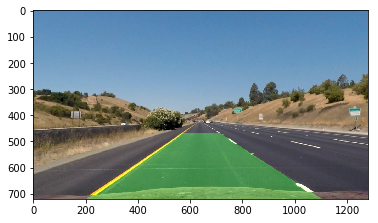

In [13]:
def draw_detected_lane(warped, left_fitx, right_fitx, ploty, M_inv, original_img):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    image_shape = original_img.shape
    height = image_shape[0]
    width = image_shape[1]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_inv, (width, height) , flags=cv2.INTER_LINEAR)
    # Combine the result with the original image
    result = cv2.addWeighted(original_img, 1, newwarp, 0.3, 0)
    return result

result = draw_detected_lane(warped, left_fitx, right_fitx, ploty, M_inv, img)
plt.imshow(result)


Draw the curvature data and offset from centre on the original image

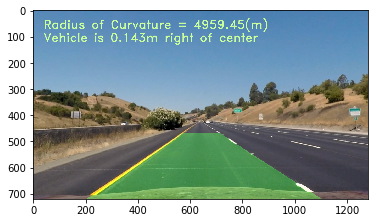

In [14]:
def draw_data(original_img, curvature_rad, center_distance):
    new_img = np.copy(original_img)
    height = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Radius of Curvature = ' + '{:04.2f}'.format(curvature_rad) + '(m)'
    cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if center_distance > 0:
        direction = 'right'
    elif center_distance < 0:
        direction = 'left'
    abs_center_distance = abs(center_distance)
    text = 'Vehicle is {:04.3f}'.format(abs_center_distance) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return new_img

result = draw_data(result, average_curve, center_offset_mtr)
plt.imshow(result)

<h2> Final Pipeline

In [15]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #number of detected pixels
        self.px_count = None
        
    def add_fit(self, fit, inds):
        if fit is not None:
            if self.best_fit is not None:
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.001 or self.diffs[1] > 1.0 or self.diffs[2] > 100.) and len(self.current_fit) > 0:
                self.detected = False
            else:
                self.detected = True
                self.px_count = np.count_nonzero(inds)
                self.current_fit.append(fit)
                if len(self.current_fit) > 5:
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                self.best_fit = np.average(self.current_fit, axis=0)
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                self.best_fit = np.average(self.current_fit, axis=0)
                
def final_pipeline(img):
    image_shape = img.shape
    undistorted = undistort_image(img, mtx, dist) #undistort the image
    thresholded = retrieve_thresholded_image(undistorted) #apply thresholding
    M, M_inv, warped, points = calculate_perspective_transorm(image_shape, thresholded) # warp the image
    
    # if both left and right lines were detected in the last frame, apply polyfit_based_on_previous_frame, otherwise apply sliding_window_search 
    if not left_line.detected or not right_line.detected:
        leftx_position, rightx_position, _ = calculate_histogram(warped)
        left_fit, right_fit, left_lane_inds, right_lane_inds, _ = sliding_window_search(warped, leftx_position, rightx_position)
    else:
        left_fit, right_fit, left_lane_inds, right_lane_inds = polyfit_based_on_previous_frame(warped, left_line.best_fit, right_line.best_fit)

    left_line.add_fit(left_fit, left_lane_inds)
    right_line.add_fit(right_fit, right_lane_inds)
    
    # draw the current best fit
    if left_line.best_fit is not None and right_line.best_fit is not None:
        ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
        left_fitx = left_line.best_fit[0]*ploty**2 + left_line.best_fit[1]*ploty + left_line.best_fit[2]
        right_fitx = right_line.best_fit[0]*ploty**2 + right_line.best_fit[1]*ploty + right_line.best_fit[2]
        lane_detected_image = draw_detected_lane(warped, left_fitx, right_fitx, ploty, M_inv, img)
        left_curve = compute_radius_of_curvature_in_mtrs(left_fitx)
        right_curve = compute_radius_of_curvature_in_mtrs(right_fitx)
        average_curve = (left_curve + right_curve)/2
        center_offset_mtr = compute_centre_in_mtrs(right_fitx, left_fitx, image_shape[1])
        output_image = draw_data(lane_detected_image, average_curve, center_offset_mtr)
    else:
        output_image = img
    return output_image

<h1> Test Pipeline

The pipeline was applied on the test image and results are shown below.

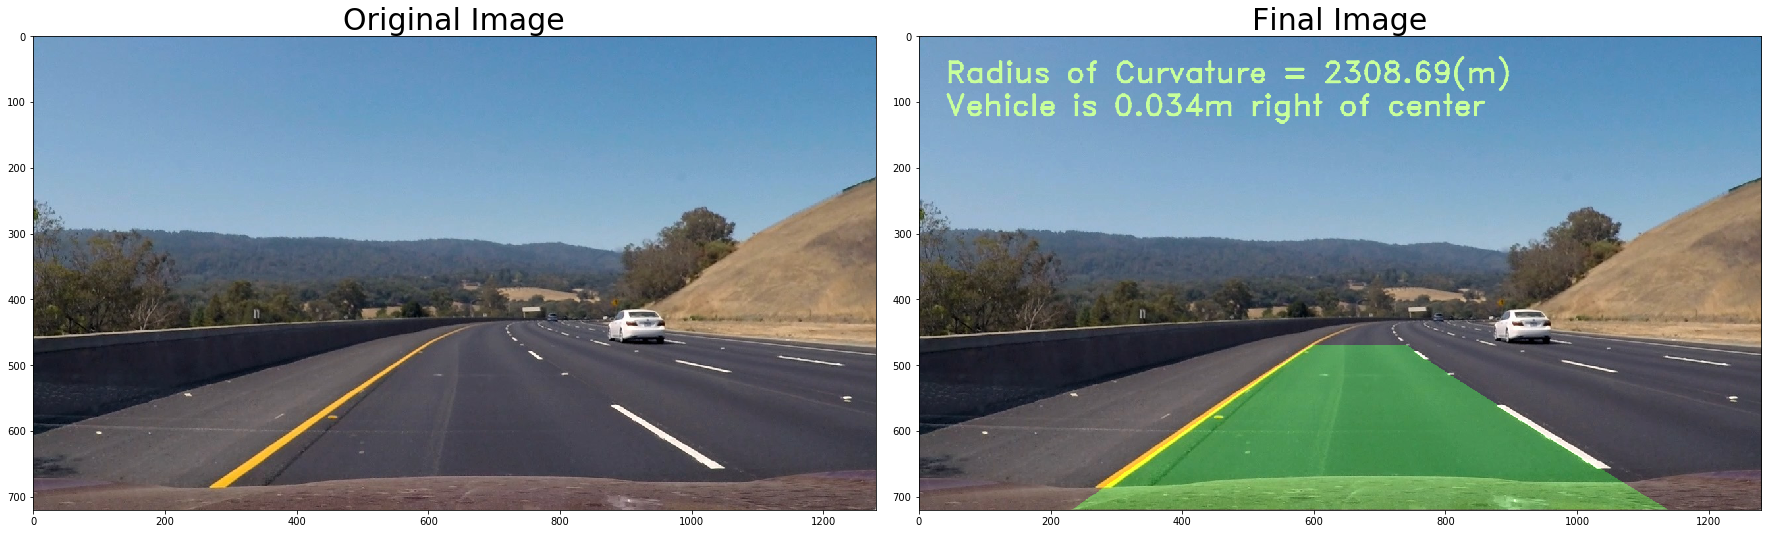

In [16]:
left_line = Line() #instantiate left line object
right_line = Line() #instantiate right line object
test_image = mpimg.imread('test_images/test3.jpg')
output_image = final_pipeline(test_image) #Apply the pipeline
plt_images(test_image, 'Original Image', output_image, 'Final Image') # plot the images

The pipeline was applied on test videos and results are saved in output_videos folder or uploaded to youtube and link is attached

In [17]:
left_line = Line()
right_line = Line()
project_video_output = 'output_videos/project_video_output.mp4'
project_video_input = VideoFileClip('test_videos/project_video.mp4')
processed_video = project_video_input.fl_image(final_pipeline)
%time processed_video.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video output_videos/project_video_output.mp4
[MoviePy] Writing video output_videos/project_video_output.mp4


100%|█████████▉| 1260/1261 [05:01<00:00,  4.34it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video_output.mp4 

CPU times: user 28min 35s, sys: 28.5 s, total: 29min 4s
Wall time: 5min 1s
